Notebook inspired from: https://github.com/JudeWells/keras_anomaly_detection

In [6]:
import os
from os import listdir,makedirs
from os.path import isfile,join
import cv2
import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D
import matplotlib.pyplot as plt
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from sklearn.neighbors import KernelDensity
import sys
np.set_printoptions(threshold=sys.maxsize)

# Data preprocessing
### Convert images to grayscale (optional)

In [7]:
path = '/Users/redl/Local Documents/Master DSBA/M1/Machine Learning/Project/leather/train/good' # Source Folder
dstpath = '/Users/redl/Local Documents/Master DSBA/M1/Machine Learning/Project/leather_grayscale/train/good' # Destination Folder
try:
    makedirs(dstpath)
except:
    print ("Directory already exist, images will be written in same folder")

files = list(filter(lambda f: isfile(join(path,f)), listdir(path)))
for image in files:
    try:
        img = cv2.imread(os.path.join(path,image))
        gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
        dstPath = join(dstpath,image)
        cv2.imwrite(dstPath,gray)
    except:
        print ("{} is not converted".format(image))

Directory already exist, images will be written in same folder


### Create ImageDataGenerators
Create generators for training (only normal images), validation (only normal images), anomaly (only outlier images) and testing (normal and outlier images). The generators include downsampling and normalization of the images.

In [35]:
image_size = 128
batch_size = 10
datagen = ImageDataGenerator(rescale=1./255)
train_generator = datagen.flow_from_directory(
    'leather_grayscale/train/',
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='input'
    )

validation_generator = datagen.flow_from_directory(
    'leather_grayscale/validation/',
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='input'
    )

anomaly_generator = datagen.flow_from_directory(
    'leather_grayscale/test/1_defective/',
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='input'
    )

test_generator = datagen.flow_from_directory(
    'leather_grayscale/test/',
    target_size=(image_size, image_size),
    batch_size=1,
    class_mode='binary'
    )

Found 245 images belonging to 1 classes.
Found 49 images belonging to 1 classes.
Found 92 images belonging to 1 classes.
Found 124 images belonging to 2 classes.


In [36]:
test_generator.class_indices

{'0_good': 0, '1_defective': 1}

# Model Definition and Training
### Convolutional Autoencoder Definition

In [10]:
# input shape must be the same size as the images that will be fed into it by the generators
# The output layer must be the same dimensions as the original image
model = Sequential()

# -------------------------------------------------------------------

# ENCODER
model.add(Conv2D(32, (3, 3), padding='same',activation='relu', input_shape=(image_size, image_size, 3)))
model.add(MaxPooling2D(pool_size=(4,4), padding='same')) # using pool_size (2,2) makes the layer 2x smaller in height and width

model.add(Conv2D(64,(3, 3),activation='relu',  padding='same'))
model.add(MaxPooling2D(pool_size=(2,2), padding='same'))

model.add(Conv2D(128,(3, 3),activation='relu',  padding='same'))
model.add(MaxPooling2D(pool_size=(2,2), padding='same'))

# -------------------------------------------------------------------

# DECODER
model.add(Conv2D(128,(3, 3),activation='relu',  padding='same'))
model.add(UpSampling2D((2, 2)))

model.add(Conv2D(64,(3, 3),activation='relu',  padding='same'))
model.add(UpSampling2D((2, 2)))

model.add(Conv2D(32,(3, 3),activation='relu',  padding='same'))
model.add(UpSampling2D((4, 4)))

model.add(Conv2D(3,(3, 3), activation='sigmoid', padding='same'))

# -------------------------------------------------------------------

model.summary()

# Compile the model
model.compile(optimizer='adadelta', loss='mean_squared_error')


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 128, 128, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 128)       

In [ ]:
# Training the model
es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=30) # Early stopping (stops training when validation doesn't improve for {patience} epochs)
model_filepath = 'models/model_1_leather.keras'
save_best = keras.callbacks.ModelCheckpoint(model_filepath, monitor='val_loss', save_best_only=True, mode='min') # Saves the best version of the model to disk (as measured on the validation data set)
model.fit_generator(
        train_generator,
        epochs=400,
        validation_data=validation_generator,
        shuffle = True,
        callbacks=[es, save_best])

In [12]:
# Training continues after improvement stops for the number of epochs equivalent to the 'patience' hyper-parameter
# To get back the model that performed best on the validation set we load the checkpointed model from disk:
model = keras.models.load_model(model_filepath)

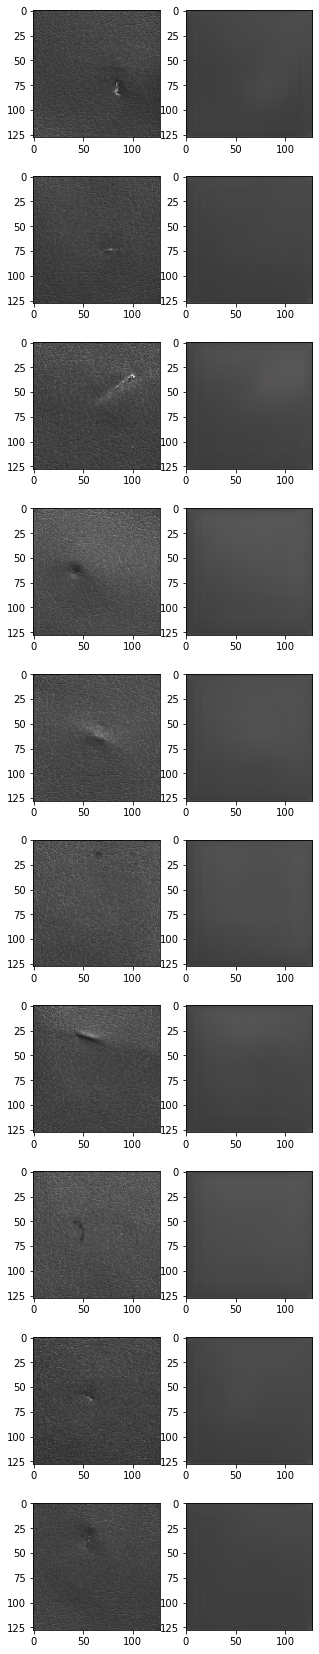

In [48]:
# Test the model by viewing a sample of original and reconstructed images
no_of_samples = 10
_, axs = plt.subplots(no_of_samples, 2, figsize=(5, 30))
axs = axs.flatten()
imgs = []      
for i in range(no_of_samples//anomaly_generator.batch_size+1):
    img, label = anomaly_generator.next()
    reconstruction = model.predict(img)
    for j in range(anomaly_generator.batch_size):
        r = reconstruction[j]
        imgs.append(img[j])
        imgs.append(r)
for img, ax in zip(imgs, axs):
    ax.imshow(img)
plt.show()

# Calculating reconstruction error

In [ ]:
def get_reconstruction_errors(generator):
    reconstruction_errors = []
    for i in range(generator.samples):
        img, _ = generator.next()
        reconstruction = model.predict([img])
        reconstruction_error = model.evaluate([reconstruction], [img], batch_size=1)
        print(reconstruction_error)
        reconstruction_errors.append(reconstruction_error)
    return reconstruction_errors

# Reconstruction errors of the different generators
train_reconstruction_error = get_reconstruction_errors(train_generator)
val_reconstruction_error = get_reconstruction_errors(validation_generator)

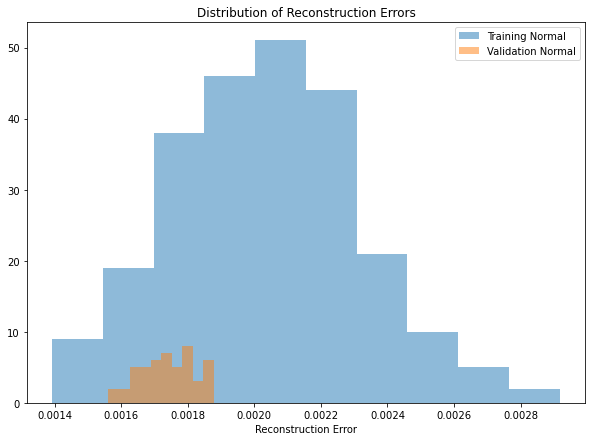

In [15]:
# Plotting the reconstruction error distributions of the training and validation data to determine thresholds
plt.figure(figsize = (10,7))
plt.title('Distribution of Reconstruction Errors')
plt.hist(train_reconstruction_error, alpha=0.5, label='Training Normal')
plt.hist(val_reconstruction_error, alpha=0.5, label='Validation Normal')
plt.legend(loc='upper right')
plt.xlabel('Reconstruction Error')

plt.show()

# Calculating kernel density

In [ ]:
# We build a replica of the first half of the auto-encoder (the encoder only)
# This network takes a an image which is 128x128x3 and compresses it down to a 8x8x8 tensor
encoder_replica = Sequential()
encoder_replica.add(Conv2D(32, (3, 3), padding='same',activation='relu', input_shape=(image_size, image_size, 3), weights=model.layers[0].get_weights()) )
encoder_replica.add(MaxPooling2D(pool_size=(4,4), padding='same'))
encoder_replica.add(Conv2D(64,(3, 3),activation='relu',  padding='same', weights=model.layers[2].get_weights()))
encoder_replica.add(MaxPooling2D(pool_size=(2,2), padding='same'))
encoder_replica.add(Conv2D(128,(3, 3),activation='relu',  padding='same', weights=model.layers[4].get_weights()))
encoder_replica.add(MaxPooling2D(pool_size=(2,2), padding='same'))
encoder_replica.summary()

In [17]:
# Creating encoded (compressed versions of the training and validation images) and getting their density
# The SKLearn kernel density function only works with 1D arrays so we need to flatten the tensors created by the encoder
encoded_images = encoder_replica.predict_generator(train_generator)
encoded_images_flat = [np.reshape(img, (8192)) for img in encoded_images]

validation_encoded = encoder_replica.predict_generator(validation_generator)
val_enc_flat = [np.reshape(img, (8192)) for img in validation_encoded]

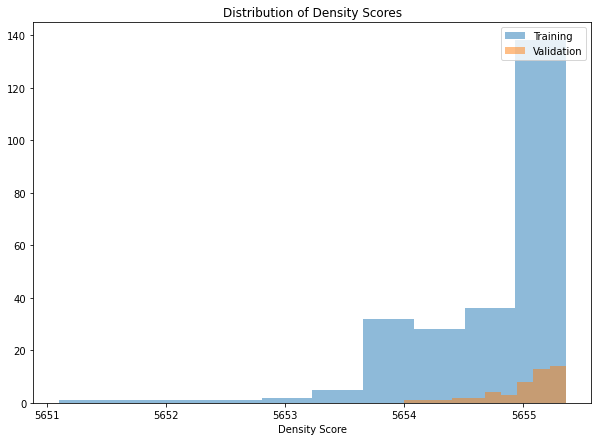

In [18]:
# Kernel Density Estimation of the encoded vectors
kde = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(encoded_images_flat)
training_density_scores = kde.score_samples(encoded_images_flat) 
validation_density_scores = kde.score_samples(val_enc_flat)
#print(training_density_scores)

# Plotting the density distributions of the training and validation data
plt.figure(figsize = (10,7))
plt.title('Distribution of Density Scores')
plt.hist(training_density_scores, alpha=0.5, label='Training')
plt.hist(validation_density_scores, alpha=0.5, label='Validation')
plt.legend(loc='upper right')
plt.xlabel('Density Score')

plt.show()

# Defining thresholds for outliers and evaluating model

In [43]:
def check_anomaly(img):
    density_threshold = 5651 # Chosen based on the distribution of the density scores of of non-outlier data (training and validation data)
    reconstruction_error_threshold = 0.003 # Chosen based on the distribution of reconstruction errors of non-outlier data (training and validation data)
    encoded_img = encoder_replica.predict([img]) # Create a compressed version of the image using the encoder
    encoded_img = [np.reshape(img, (8192)) for img in encoded_img] # Flatten the compressed image
    density = kde.score_samples(encoded_img)[0] # get a density score for the new image
    print(f'density: {density}')
    reconstruction = model.predict([img])
    reconstruction_error = model.evaluate([reconstruction], [img], batch_size=1)
    print(f'reconstruction_error: {reconstruction_error}')
    if density < density_threshold or reconstruction_error > reconstruction_error_threshold:
        return 1
    else:
        return 0

In [ ]:
from sklearn.metrics import f1_score

y_true = []
y_pred = []
for i in range(test_generator.samples):
    img, label = test_generator.next()
    y_true.append(label)
    y_pred.append(check_anomaly(img))
f1_score(y_true, y_pred)

In [45]:
f1_score(y_true, y_pred)

0.7150259067357513

# Verifying distribution of reconstruction error of anomalous data
Ideally the reconstruction error of anomalous data should be higher then those of normal data and above the chosen threshold of 0.005

In [ ]:
anom_reconstruction_error = get_reconstruction_errors(anomaly_generator)

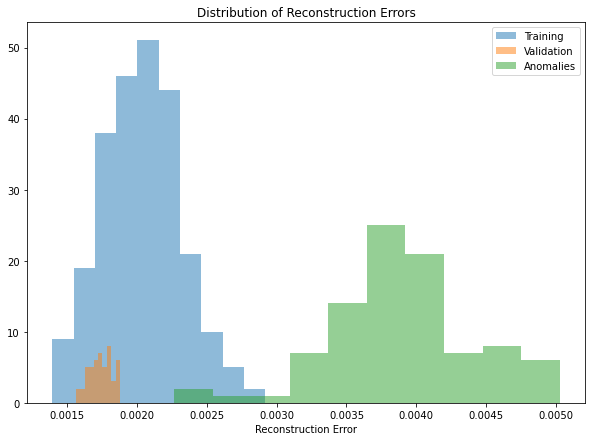

In [26]:
# Plotting the reconstruction error distributions of the training (normal), validation (normal) and anomalous images
# Ideally we want to see high separation between the normal and anomalous classes
plt.figure(figsize = (10,7))
plt.title('Distribution of Reconstruction Errors')
plt.hist(train_reconstruction_error, alpha=0.5, label='Training')
plt.hist(val_reconstruction_error, alpha=0.5, label='Validation')
plt.hist(anom_reconstruction_error, alpha=0.5, label='Anomalies')
plt.legend(loc='upper right')
plt.xlabel('Reconstruction Error')

plt.show()

# Verifying distribution of kernel density of anomalous data
Ideally the kernel density of anomalous data should be lower then the kernel density of normal data and below the chosen threshold of 5630.

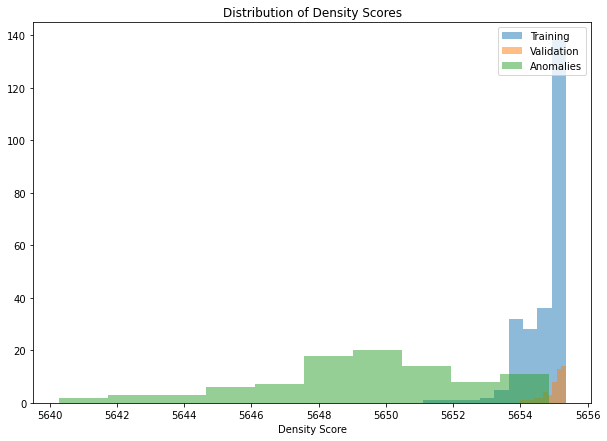

In [42]:
anom_encoded = encoder_replica.predict_generator(anomaly_generator)
anom_enc_flat = [np.reshape(img, (8192)) for img in anom_encoded]
anomaly_density_scores = kde.score_samples(anom_enc_flat)

# Kernel Density Estimation of the encoded vectors
kde = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(encoded_images_flat)
training_density_scores = kde.score_samples(encoded_images_flat) 
validation_density_scores = kde.score_samples(val_enc_flat)

# Plotting the density distributions of the training, validation and anomalous data
plt.figure(figsize = (10,7))
plt.title('Distribution of Density Scores')
plt.hist(training_density_scores, alpha=0.5, label='Training')
plt.hist(validation_density_scores, alpha=0.5, label='Validation')
plt.hist(anomaly_density_scores, alpha=0.5, label='Anomalies')
plt.legend(loc='upper right')
plt.xlabel('Density Score')

plt.show()